In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from tqdm import tqdm
import cmocean as cm
import sys, os
from datetime import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
from dask.distributed import Client
import xarray as xr
import numpy as np
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Load workers:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46845,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:38895,Total threads: 1
Dashboard: /proxy/33441/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:45997,


In [3]:
time_coord = slice('1982-01-01','2023-12-31')

### When I did this initially, had to split up my data into -80 to -70 then -70 to -63, this is hugely computationally expensive
yt_coord = slice(-80,-63)
xt_coord = slice(-60,40)

In [4]:
SSTa = xr.open_mfdataset(['/scratch/e14/ts7341/SSTa.nc',
                          '/scratch/e14/ts7341/SSTa_early_period.nc'])

In [5]:
SSTa

<xarray.Dataset> Size: 24GB
Dimensions:    (time: 15338, lat: 266, lon: 1440)
Coordinates:
  * lat        (lat) float64 2kB -81.08 -80.97 -80.87 ... -50.46 -50.3 -50.14
  * lon        (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
    dayofyear  (time) int64 123kB dask.array<chunksize=(6574,), meta=np.ndarray>
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
Data variables:
    sst        (time, lat, lon) float32 24GB dask.array<chunksize=(6574, 266, 1440), meta=np.ndarray>

In [6]:
import glob
import xarray as xr
import re

# Get a list of all NetCDF files
filelist = glob.glob('/g/data/e14/asg561/MHW_xarray/mhw_data_90pc/mhw*.nc')

# Define a regex pattern to match latitudes -90to-70 or -70to-50
pattern = re.compile(r'\.(-90to-70|-70to-50)\.')

# Filter the file list based on the pattern
filtered_files = [f for f in filelist if pattern.search(f)]

# Check if there are matching files
if filtered_files:
    # Open only the filtered files
    satellite_data = xr.open_mfdataset(filtered_files, combine='by_coords')
    print(satellite_data)
else:
    print("No matching files found!")

NOAA_SSTa = satellite_data.sel(time = slice('1982-01-01','2023-12-29')).\
                            sel(lat = slice(-82,-50))

<xarray.Dataset> Size: 59GB
Dimensions:         (time: 15688, lat: 160, lon: 1440, time366: 366)
Coordinates:
  * lat             (lat) float32 640B -89.88 -89.62 -89.38 ... -50.38 -50.12
  * lon             (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time            (time) datetime64[ns] 126kB 1981-12-30 ... 2024-12-11
  * time366         (time366) datetime64[ns] 3kB 1983-12-30 ... 1984-12-29
Data variables:
    severity        (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    severity_index  (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ssta            (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    sst             (time, lat, lon) float32 14GB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology90   (time366, lat, lon) float32 337MB dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    climatology     (time366, lat, lon) float32 337MB d

In [7]:
import numpy as np
import xarray as xr

# --- Convert longitudes from 0-360 to -180 to 180 ---
print("Converting longitudes from 0-360 to -180 to 180...")

SSTa['lon'] = ((SSTa['lon'] + 180) % 360) - 180

# Sort the coordinates to ensure monotonic increase for xESMF
SSTa = SSTa.sortby('lon')
print("Longitudes converted and sorted.")

# Optional sanity check
print(f"Longitude range: {SSTa.lon.min().values} to {SSTa.lon.max().values}")


Converting longitudes from 0-360 to -180 to 180...
Longitudes converted and sorted.
Longitude range: -179.875 to 179.875


In [8]:
model_aligned_time = SSTa.sst


model_da = model_aligned_time.sel(lat=slice(-70, -63)).chunk({'time': -1})
model_da = model_da.sel(time = slice('1982','2023-12-29'))

In [9]:
model_da

<xarray.DataArray 'sst' (time: 15338, lat: 66, lon: 1440)> Size: 6GB
dask.array<rechunk-merge, shape=(15338, 66, 1440), dtype=float32, chunksize=(15338, 66, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 528B -69.99 -69.88 -69.78 ... -63.28 -63.17 -63.06
  * lon        (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    dayofyear  (time) int64 123kB dask.array<chunksize=(15338,), meta=np.ndarray>
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...

In [10]:
NOAA_SSTa['time'] = NOAA_SSTa['time'] + np.timedelta64(12, 'h')

In [11]:
sat_aligned_time = satellite_data.ssta
satellite_da = sat_aligned_time.chunk({'time':-1})

In [12]:
import numpy as np

# Convert longitudes from 0–360 to -180–180
satellite_da = satellite_da.assign_coords(
    lon=((satellite_da.lon + 180) % 360) - 180
)

# Sort the longitudes so they are monotonically increasing
satellite_da = satellite_da.sortby('lon')

# Optional: sanity check
print(f"Longitude range after conversion: {satellite_da.lon.min().values} to {satellite_da.lon.max().values}")


Longitude range after conversion: -179.875 to 179.875


In [13]:
sat_da = satellite_da.sel(lat = slice(-70, -63)).sel(time = slice('1982','2023-12-29'))#.isel(lon=lon_mask)

sat_da['time'] = sat_da['time'] + np.timedelta64(12, 'h')
sat_da = sat_da.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 28.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [14]:
import numpy as np
import xarray as xr
from scipy.stats import t

## Regridding using the xe.Regridder tool from Cosima cookbook recipe
regridder = xe.Regridder(model_da, sat_da, 'bilinear')
model_regridded = regridder(model_da)

print("Regridding complete.")
print("Satellite Data Shape:  ", sat_da.shape)
print("Regridded Model Shape: ", model_regridded.shape)


--- Step 1: Aligning Grids ---
Regridding complete.
Satellite Data Shape:   (15338, 28, 1440)
Regridded Model Shape:  (15338, 28, 1440)


In [15]:
model_regridded = model_regridded.load()

In [16]:
# Compute lag-1 autocorrelation
def lag1_autocorr(x):
    return np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else 0

# Correlation with effective sample size (Neff) and adjusted p-value
def corr_with_autocorr(x, y):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    N = len(x)
    if N < 5:
        return np.nan, np.nan, np.nan

    r = np.corrcoef(x, y)[0, 1]

    # Effective sample size
    r1, r2 = lag1_autocorr(x), lag1_autocorr(y)
    Neff = N * (1 - r1*r2) / (1 + r1*r2)
    Neff = max(3, Neff)  # avoid too small df

    # Adjusted t-test
    tval = r * np.sqrt((Neff - 2) / (1 - r**2))
    pval = 2 * (1 - t.cdf(abs(tval), df=Neff-2))
    return r, Neff, pval

# Apply across grid cells
def gridcell_correlation(sat, model):
    return xr.apply_ufunc(
        corr_with_autocorr,
        sat, model,
        input_core_dims=[["time"], ["time"]],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, float]
    )


In [17]:
# Loop over months 1-12
all_months = []

for month in range(1, 13):
    print(f"\n--- Processing month {month} ---")
    
    # Select all daily values of this month across all years
    sat_m = sat_da.sel(time=sat_da['time.month'] == month)
    model_m = model_regridded.sel(time=model_regridded['time.month'] == month)

    # Compute correlation, effective sample size, and p-value
    r, Neff, pval = gridcell_correlation(sat_m, model_m)

    # Create a dataset for this month
    ds_month = xr.Dataset({
        "r": r,        
        "Neff": Neff,
        "pval": pval
    }, coords={"lat": sat_da.lat, "lon": sat_da.lon})
    
    # Add a month dimension
    ds_month = ds_month.expand_dims(month=[month])
    
    # Append to list
    all_months.append(ds_month)

# Concatenate all months along the 'month' dimension
ds_all = xr.concat(all_months, dim='month')

# Optional: save full dataset to NetCDF
ds_all.to_netcdf("/scratch/e14/ts7341/full_corr/full_corr_lower_lats.nc")
print("Saved combined correlation dataset with month dimension.")



--- Processing month 1 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 2 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 3 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 4 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 5 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 6 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 7 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 8 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 9 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 10 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 11 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



--- Processing month 12 ---


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Saved combined correlation dataset with month dimension.


## Plot the Correlation

In [3]:
ds = xr.open_dataset('/scratch/e14/ts7341/full_corr.nc')
ds

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/e14/ts7341/full_corr.nc'

In [4]:
ds = xr.open_dataset('/scratch/e14/ts7341/full_corr/full_corr_high_lats.nc')
ds

<xarray.Dataset> Size: 12MB
Dimensions:  (month: 12, lat: 28, lon: 1440)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 112B -76.88 -76.62 -76.38 ... -70.62 -70.38 -70.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    r        (month, lat, lon) float64 4MB ...
    Neff     (month, lat, lon) float64 4MB ...
    pval     (month, lat, lon) float64 4MB ...

In [4]:
ds = xr.open_mfdataset(['/scratch/e14/ts7341/full_corr/full_corr_lower_lats.nc',
                        '/scratch/e14/ts7341/full_corr/full_corr_high_lats.nc'])
ds

<xarray.Dataset> Size: 23MB
Dimensions:  (month: 12, lat: 56, lon: 1440)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 224B -76.88 -76.62 -76.38 ... -63.62 -63.38 -63.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    r        (month, lat, lon) float64 8MB dask.array<chunksize=(12, 28, 1440), meta=np.ndarray>
    Neff     (month, lat, lon) float64 8MB dask.array<chunksize=(12, 28, 1440), meta=np.ndarray>
    pval     (month, lat, lon) float64 8MB dask.array<chunksize=(12, 28, 1440), meta=np.ndarray>

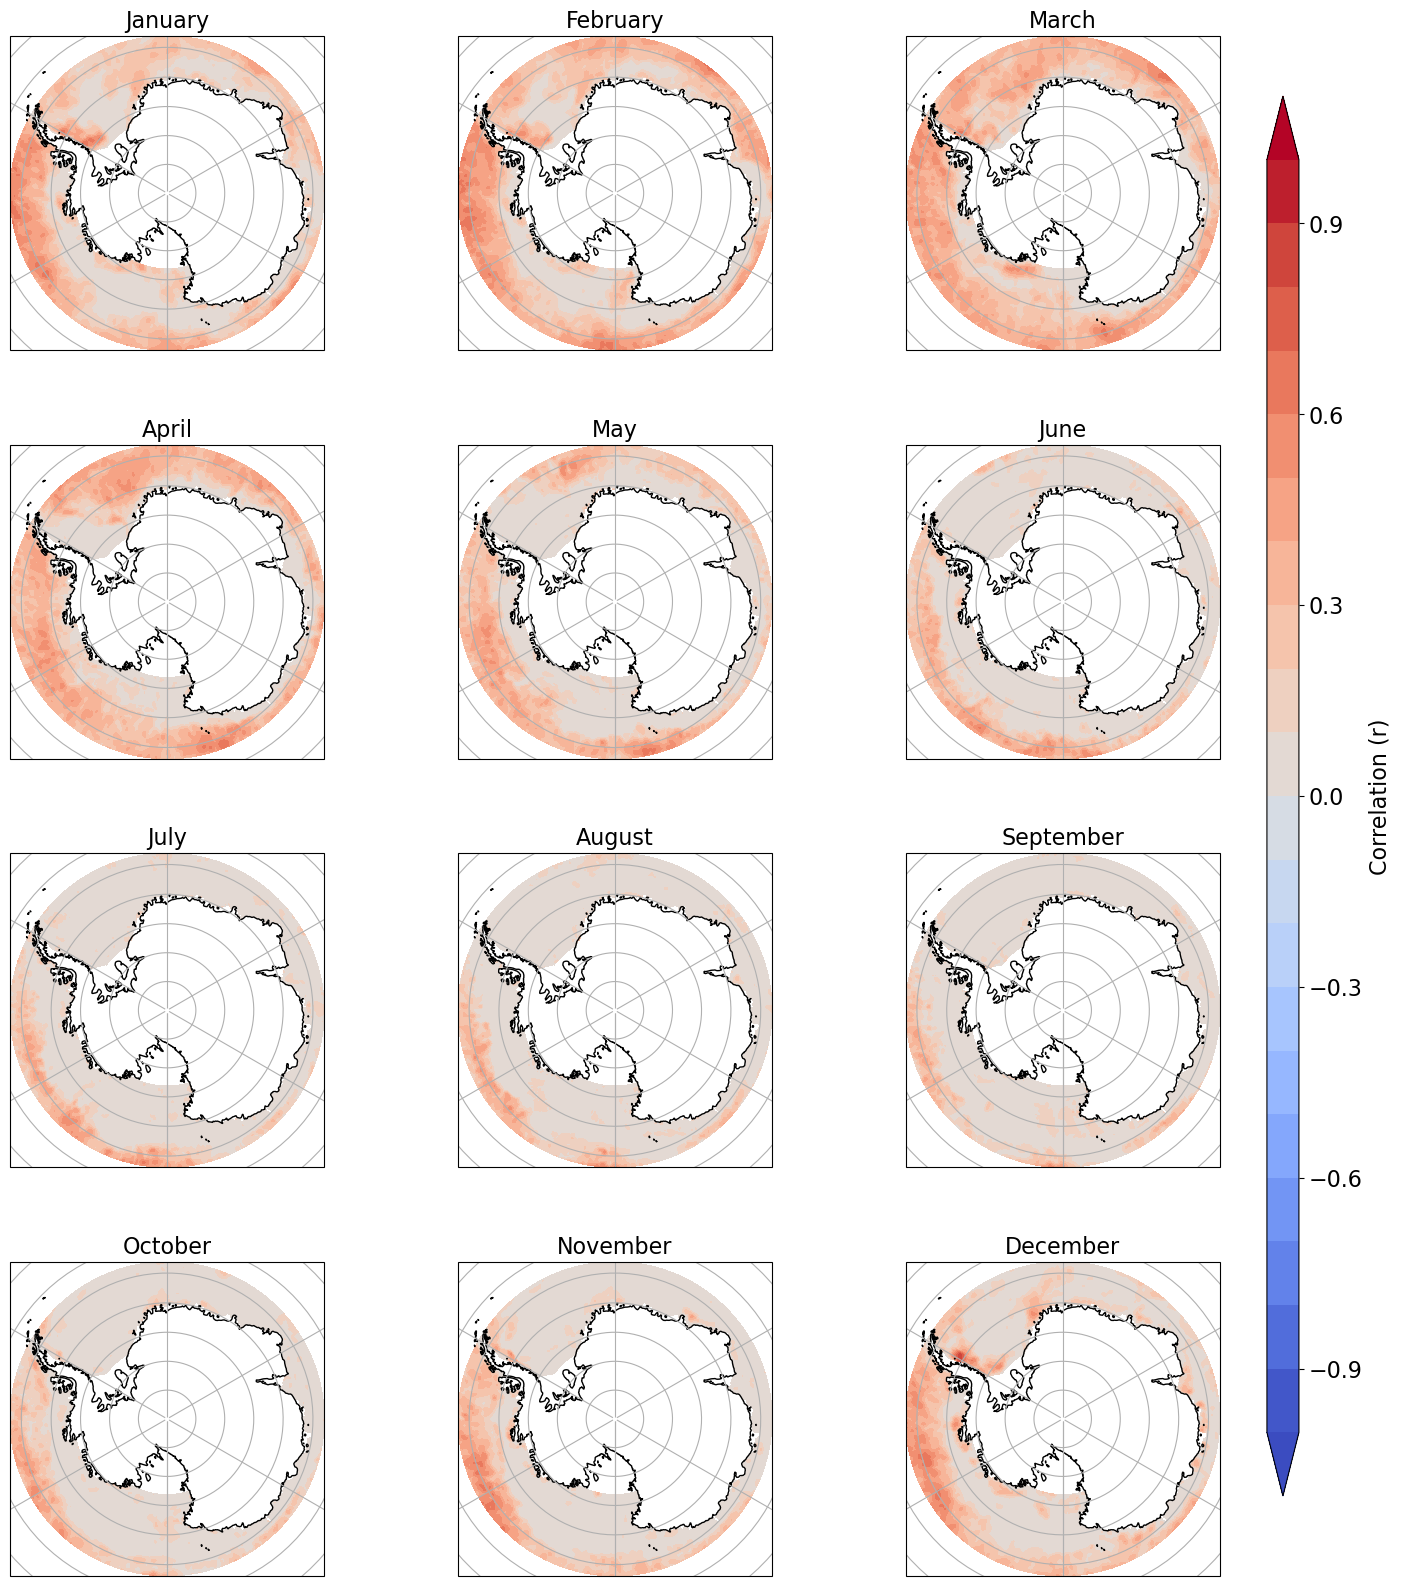

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature # Import for land/ocean features
import numpy as np
import calendar

# Define the specific months to plot
months_to_plot = [12, 1, 2, 3]

# Define your significance level (alpha)
alpha = 0.05

# Create a 2x2 grid for the four plots
fig, axes = plt.subplots(2, 2,
                         figsize=(16, 15), # Keeping the larger size
                         subplot_kw={'projection': ccrs.SouthPolarStereo()})

# Loop through the axes and the list of months to plot
for i, ax in enumerate(axes.flat):
    if i >= len(months_to_plot):
        ax.set_visible(False)
        continue

    month_val = months_to_plot[i]

    # Select data directly from the ds using the month dimension
    r = ds.r.sel(month=month_val)
    p_values = ds.pval.sel(month=month_val)
    lat = ds.lat
    lon = ds.lon

    # Main color contour plot for correlation values
    cf = ax.contourf(lon, lat, r,
                     levels=np.linspace(-1, 1, 21),
                     transform=ccrs.PlateCarree(),
                     cmap='coolwarm', extend='both',
                     zorder=0)

    # Hatching for non-significant areas
    ax.contourf(lon, lat, p_values,
                levels=[alpha, 1],
                colors='none',
                hatches=["///"],
                transform=ccrs.PlateCarree(),
                zorder=2)

    # Color the landmass gray
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)

    # Add coastlines
    ax.coastlines(resolution='50m', zorder=3)

    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.6)

    # Set the title for each subplot
    month_name = calendar.month_name[month_val]
    ax.set_title(month_name, fontsize=20)

# plt.tight_layout()

# fig.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/correlation.png',    
#             dpi=800,              
#             bbox_inches='tight')   

# plt.show()